# Session 1 - Linear Regression

*Matteo Courthoud*

## Contents

- [Simple Linear Regression](#/2)
- [Multiple Linear Regression](#/24)
- [Other Considerations in the Regression Model](#/32)

In [1]:
# Import everything
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from numpy.linalg import inv
from numpy.random import normal as rnorm
from statsmodels.stats.outliers_influence import OLSInfluence

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

In [ ]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Enable slideshow
!jupyter nbextension enable rise --py --sys-prefix

Enabling notebook extension rise/main...
      - Validating: OK


You can inspect all the available global parameter options [here](https://matplotlib.org/3.3.2/tutorials/introductory/customizing.html).

## 1.1 Simple Linear Regression

[*back to index*](#/1)

First, let's load the Advertising dataset. It contains information on displays sales (in thousands of units) for a particular product and a list of advertising budgets (in thousands of dollars) for TV, radio, and newspaper media.

We open the dataset using the `pandas` library which is **the** library for datasets in Python.`

In [89]:
# Advertisement spending data
advertising = pd.read_csv('data/Advertising.csv', usecols=[1,2,3,4])

Let's have a look at the content. We can have a glance at the first rows by using the function `head`.

In [5]:
# Preview of the data
advertising.head()

TV  Radio  Newspaper  Sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9

We can have a general overview of the dataset using the function `info`.

In [6]:
# Overview of all variables
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


We can have more information on the single varaibles using the function `describe`.

In [7]:
# Summary of all variables
advertising.describe()

TV       Radio   Newspaper       Sales
count  200.000000  200.000000  200.000000  200.000000
mean   147.042500   23.264000   30.554000   14.022500
std     85.854236   14.846809   21.778621    5.217457
min      0.700000    0.000000    0.300000    1.600000
25%     74.375000    9.975000   12.750000   10.375000
50%    149.750000   22.900000   25.750000   12.900000
75%    218.825000   36.525000   45.100000   17.400000
max    296.400000   49.600000  114.000000   27.000000

If you just want to call a variable in `pandas`, you have 3 options:
1. use squared brackets as if the varaible was a component of a dictionary
2. use or dot subscripts as if the variable was a function of the data
3. use the `loc` function (best practice)

In [8]:
# 1. Brackets
advertising['TV']

0      230.1
1       44.5
2       17.2
3      151.5
4      180.8
       ...  
195     38.2
196     94.2
197    177.0
198    283.6
199    232.1
Name: TV, Length: 200, dtype: float64

In [9]:
# 2. Brackets
advertising.TV

0      230.1
1       44.5
2       17.2
3      151.5
4      180.8
       ...  
195     38.2
196     94.2
197    177.0
198    283.6
199    232.1
Name: TV, Length: 200, dtype: float64

In [10]:
# The loc function
advertising.loc[:,'TV']

0      230.1
1       44.5
2       17.2
3      151.5
4      180.8
       ...  
195     38.2
196     94.2
197    177.0
198    283.6
199    232.1
Name: TV, Length: 200, dtype: float64

Note that the `loc` function is more powerful and is generally used to subset lines and columns.

In [11]:
# Select multiple columns and subset of rows
advertising.loc[0:5,['Sales','TV']]

Sales     TV
0   22.1  230.1
1   10.4   44.5
2    9.3   17.2
3   18.5  151.5
4   12.9  180.8
5    7.2    8.7

Suppose we are interested in the (linear) relationship between sales and tv advertisement.

$$
sales ≈ \beta_0 + \beta_1 TV.
$$

How are the two two variables related? Visual inspection: scatterplot.

In [12]:
# Figure 3.1
def make_fig_3_1a():
    
    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('Figure 3.1');

    # Plot scatter and best fit line
    sns.regplot(x=advertising.TV,  y=advertising.Sales, 
                ax=ax, order=1, ci=None, line_kws={'color':'r'})
    ax.set_xlim(-10,310); ax.set_ylim(ymin=0)
    ax.legend(['Least Squares Fit','Data']);

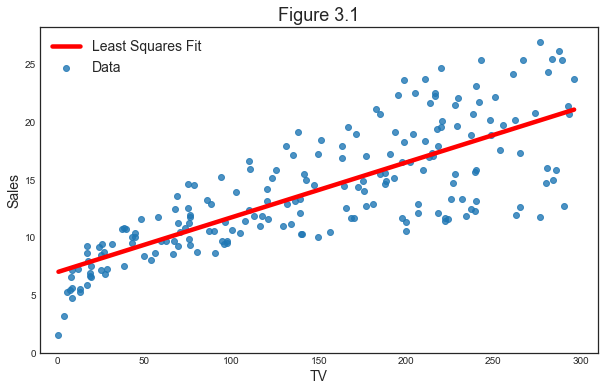

In [13]:
make_fig_3_1a()

### Estimating the Coefficients

How do we estimate the best fit line? Minimize the Residual Sum of Squares (RSS).

First, suppose we have a dataset $\mathcal D = \{x_i, y_i\}_{i=1}^N$. We define the prediction of $y$ based on $X$ as

$$
\hat y_i = \hat \beta X_i
$$

The residuals are the unexplained component of $y$

$$
e_i = y_i - \hat y_i
$$

Our objective function (to be minimized) is the Resdual Sum of Squares (RSS):

$$
RSS := \sum_{n=1}^N e_i^2
$$

And the OLS coefficient is defined as its minimizer:

$$
\hat \beta_{OLS} := \arg\min_{\beta} \sum_{n=1}^N e_i^2 = \arg\min_{\beta} \sum_{n=1}^N (y_i - X_i \beta)^2
$$

Let's use the `sklearn` library to fit a linear regression model of *Sales* on *TV* advertisement.

In [14]:
# Define X and y
X = advertising.TV.values.reshape(-1,1)
y = advertising.Sales.values

# Fit linear regressions
reg = LinearRegression().fit(X,y)
print(reg.intercept_)
print(reg.coef_)

7.0325935491276885
[0.04753664]


We can visualize the residuals as the vertical distances between the data and the prediction line. The objective function RSS is the sum of the squares of the lengths of vertical lines.

In [15]:
# Compute predicted values
y_hat = reg.predict(X)

# Figure 3.1
def make_figure_3_1b():

    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('Figure 3.1');

    # Add residuals
    sns.regplot(x=advertising.TV, y=advertising.Sales, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':20})
    ax.vlines(X, np.minimum(y,y_hat), np.maximum(y,y_hat), linestyle='--', color='k', alpha=0.5, linewidth=1)
    plt.legend(['Least Squares Fit','Data','Residuals']);

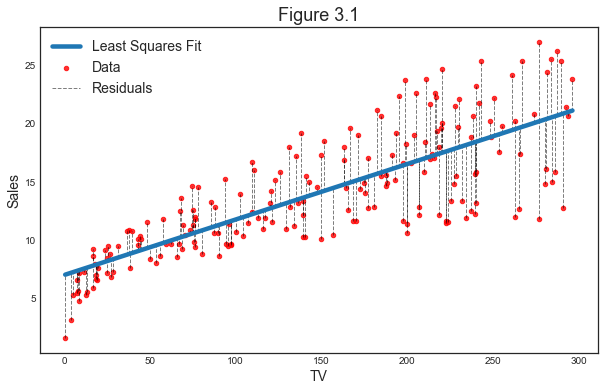

In [16]:
make_figure_3_1b()

The closed form solution in matrix algebra is
$$
\hat \beta_{OLS} = (X'X)^{-1}(X'y)
$$

Python has a series of shortcuts to make the syntax less verbose. However, we still need to import the `inv` function from `numpy`. In Matlab it would be `(X'*X)^{-1}*(X'*y)`, almost literal.

In [17]:
# Compute OLS coefficient with matrix algebra
beta = inv(X.T @ X) @ X.T @ y

print(beta)

[0.08324961]


Why is the result different?

We are missing one coefficient: the intercept. Our regression now looks like this

In [18]:
# New figure 1
def make_new_figure_1():

    # Init figure
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Role of the Intercept')

    # Add new line on the previous plot
    sns.regplot(x=advertising.TV, y=advertising.Sales, ax=ax, order=1, ci=None, scatter_kws={'color':'r', 's':9})
    ax.plot(X, beta*X, color='g')
    plt.xlim(-10,310); plt.ylim(ymin=0);
    ax.legend(['With Intercept', 'Without intercept']);

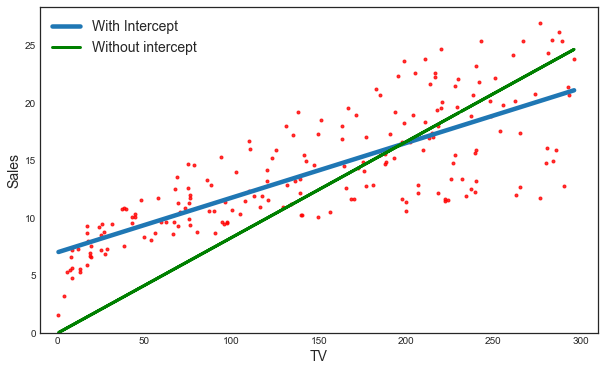

In [19]:
make_new_figure_1()

How do we insert an intercept using matrix algebra? We add a column of ones.

$$
X_1 = [\boldsymbol{1}, X]
$$

In [20]:
# How to insert intercept? Add constant: column of ones
one = np.ones(np.shape(X))
X1 = np.concatenate([one,X],axis=1)

print(np.shape(X1))

(200, 2)


Now we compute again the coefficients as before.

$$
\hat \beta_{OLS} = (X_1'X_1)^{-1}(X_1'y)
$$

In [21]:
# Compute beta OLS with intercept
beta_OLS = inv(X1.T @ X1) @ X1.T @ y

print(beta_OLS)

[7.03259355 0.04753664]


Now we have indeed obtained the same exact coefficients.

What does minimizing the Residual Sum of Squares means in practice? How does the objective function looks like?

In [22]:
from sklearn.preprocessing import scale

# First, scale the data
X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.Sales
regr = LinearRegression().fit(X,y)

# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()/1000

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)/1000
min_rss

2.1025305831313514

In [23]:
# Figure 3.2 - Regression coefficients - RSS
def make_fig_3_2():
    fig = plt.figure(figsize=(15,6))
    fig.suptitle('RSS - Regression coefficients')

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    # Left plot
    CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
    ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
    ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

    # Right plot
    ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
    ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
                alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
    ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
    ax2.set_zlabel('RSS')
    ax2.set_zlim(Z.min(),Z.max())
    ax2.set_ylim(0.02,0.07)

    # settings common to both plots
    for ax in fig.axes:
        ax.set_xlabel(r'$\beta_0$')
        ax.set_ylabel(r'$\beta_1$')
        ax.set_yticks([0.03,0.04,0.05,0.06])
        ax.legend()

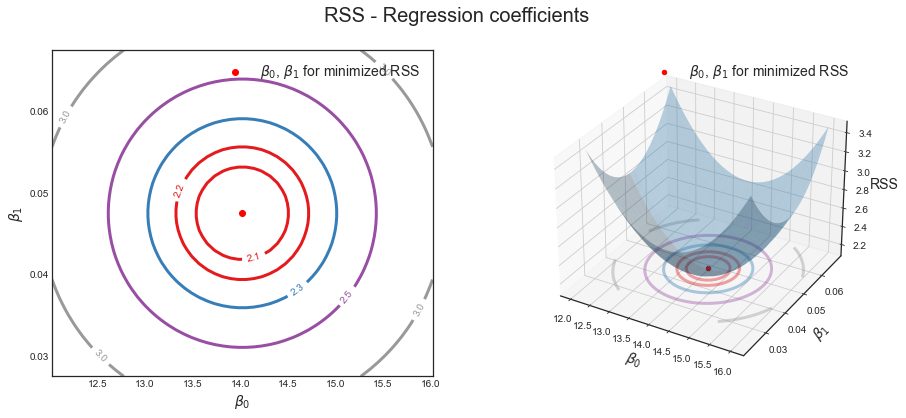

In [24]:
make_fig_3_2()

### Assessing the Accuracy of the Coefficient Estimates

How accurate is our regression fit? Suppose we were drawing different (small) samples from the same data generating process, for example

$$
y_i = 2 + 3x_i + \varepsilon_i
$$

where $x_i \sim N(0,1)$ and $\varepsilon \sim N(0,3)$.

In [25]:
# Init
N = 30;
K = 100;
beta_hat = np.zeros((2,K))
x = np.linspace(-4,4,N)

# Set seed
np.random.seed(1)

# K simulations
for i in range(K):
    # Simulate data
    x1 = np.random.normal(0,1,N).reshape([-1,1])
    X = np.concatenate([np.ones(np.shape(x1)), x1], axis=1)
    epsilon = np.random.normal(0,5,N)
    beta0 = [2,3]
    y = X @ beta0 + epsilon

    # Estimate coefficients
    beta_hat[:,i] = inv(X.T @ X) @ X.T @ y

In [26]:
# new figure 2
def make_new_fig_2():

    # Init figure
    fig, ax = plt.subplots(1,1)
    
    for i in range(K):
        # Plot line
        ax.plot(x, beta_hat[0,i] + x*beta_hat[1,i], color='blue', alpha=0.2, linewidth=1)
        if i==K-1:
            ax.plot(x, beta_hat[0,i] + x*beta_hat[1,i], color='blue', alpha=0.2, linewidth=1, label='Estimated Lines')

    # Plot true line
    ax.plot(x, 2 + 3*x, color='red', linewidth=3, label='True Line');
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.legend();
    ax.set_xlim(-4,4);

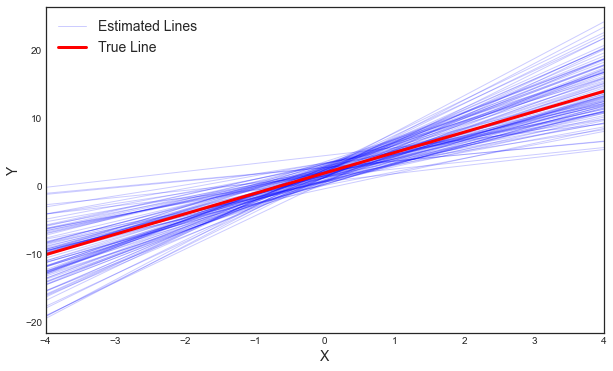

In [27]:
make_new_fig_2()

The `regplot` command lets us automatically draw confidence intervals. Let's draw the last simulated dataset with conficence intervals.

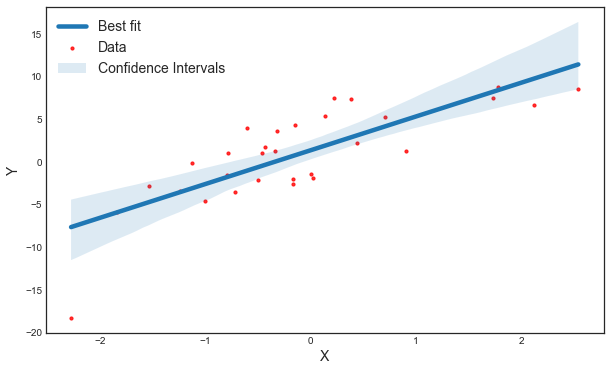

In [28]:
fig, ax = plt.subplots(1,1)

# Plot last simulation scatterplot with confidence interval
sns.regplot(x=x1, y=y, ax=ax, order=1, scatter_kws={'color':'r', 's':10});
ax.set_xlabel('X'); ax.set_ylabel('Y'); 
ax.legend(['Best fit','Data', 'Confidence Intervals']);

As we can see, depending on the sample, we get a different estimate of the linear relationship between $x$ and $y$. However, there estimates are on average correct. Indeed, we can visualize their distribution.

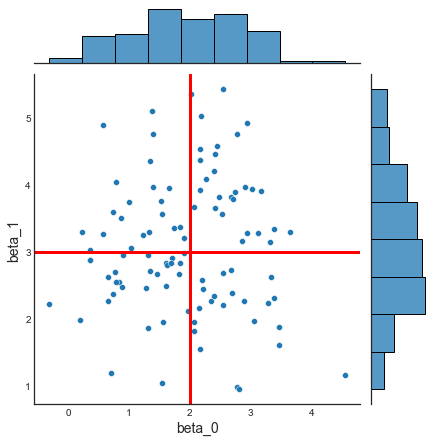

In [29]:
# Plot distribution of coefficients
plot = sns.jointplot(x=beta_hat[0,:], y=beta_hat[1,:], edgecolor="white");
plot.ax_joint.axvline(x=2, color='red');
plot.ax_joint.axhline(y=3, color='red');
plot.set_axis_labels('beta_0', 'beta_1');

How do we compute confidence intervals by hand?

$$
Var(\hat \beta_{OLS}) = \sigma^2 (X'X)^{-1}
$$

where $\sigma^2 = Var(\varepsilon)$. Since we do not know $Var(\varepsilon)$, we estimate it as $Var(e)$.

$$
\hat Var(\hat \beta_{OLS}) = \hat \sigma^2 (X'X)^{-1}
$$

If we assume the standard errors are normally distributed (or we apply the Central Limit Theorem, assuming $n \to \infty$), a 95% confidence interval for the OLS coefficient takes the form

$$
CI(\hat \beta_{OLS}) = \Big[ \hat \beta_{OLS} - 1.96 \times \hat SE(\hat \beta_{OLS}) \ , \ \hat \beta_{OLS} + 1.96 \times \hat SE(\hat \beta_{OLS}) \Big]
$$

where $\hat SE(\hat \beta_{OLS}) = \sqrt{\hat Var(\hat \beta_{OLS})}$.

In [30]:
# Import again X and y from example above
X = advertising.TV.values.reshape(-1,1)
X1 = np.concatenate([np.ones(np.shape(X)), X], axis=1)
y = advertising.Sales.values

# Compute residual variance
X_hat = X1 @ beta_OLS
e = y - X_hat
sigma_hat = np.var(e)
var_beta_OLS = sigma_hat * inv(X1.T @ X1)

# Take elements on the diagonal and square them
std_beta_OLS = [var_beta_OLS[0,0]**.5, var_beta_OLS[1,1]**.5]

print(std_beta_OLS)

[0.45554797374006717, 0.002677120350046655]


The `statsmodels` library allows us to produce nice tables with parameter estimates and standard errors.

In [31]:
# Table 3.1 & 3.2
est = sm.OLS.from_formula('Sales ~ TV', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Assessing the Accuracy of the Model

What metrics can we use to assess whether the model is a good model, in terms of capturing the relationship between the variables?

First, we can compute our objective function: the Residual Sum of Squares (*RSS*). Lower values of our objective function imply that we got a better fit.

In [32]:
# RSS with regression coefficients
RSS = sum(e**2)

print(RSS)

2102.5305831313512


The problem with *RSS* as a metric is that it's hard to compare different regressions since its scale depends on the magnitude of the variables.

One measure of fit that does not depend on the magnitude of the variables is $R^2$: the percentage of our explanatory variable explained by the model

$$
R^2 = 1 - \frac{\text{RSS}}{\text{TSS}}
$$

where

$$
TSS = \sum_{i=1}^N (y_i - \bar y)^2
$$

In [33]:
# TSS
TSS = sum( (y-np.mean(y))**2 )

# R2
R2 = 1 - RSS/TSS

print(R2)

0.6118750508500708


Can the $R^2$ metric be negative? When?

## 2.2 Multiple Linear Regression

[*go to index*](#/1)

What if we have more than one explanatory variable? Spoiler: we already did, but one was a constant.

Let's have a look at the regression of *Sales* on *Radio* and *TV* advertisement expenditure separately.

In [34]:
# Table 3.3 (1)
est = sm.OLS.from_formula('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

In [35]:
# Table 3.3 (2)
est = sm.OLS.from_formula('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

It seems that both Radio and Newspapers are positively correlated with *Sales*. Why don't we estimate a unique regression with both dependent variables?

### Estimating the Regression Coefficients

Suppose now we enrich our previous model adding all different forms of advertisement:

$$
\text{Sales} = \beta_0 + \beta_1 \text{TV} + \beta_2 \text{Radio} + \beta_3 \text{Newspaper} + \varepsilon
$$

We estimate it using the `statsmodels` `ols` library.

In [36]:
# Table 3.4
est = sm.OLS.from_formula('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Why now it seems that there is no relationship between Sales and Newspaper while the univariate regression told us the opposite?

Let's explore the correlation between those variables.

In [37]:
# Table 3.5 - Correlation Matrix
advertising.corr()

TV     Radio  Newspaper     Sales
TV         1.000000  0.054809   0.056648  0.782224
Radio      0.054809  1.000000   0.354104  0.576223
Newspaper  0.056648  0.354104   1.000000  0.228299
Sales      0.782224  0.576223   0.228299  1.000000

Let's try to inspect the relationship visually. Note that now the linear best fit is going to be 3-dimensional. In order to make it visually accessible, we consider only on *TV* and *Radio* advertisement expediture as dependent variables. The best fit will be a plane instead of a line.

In [38]:
# Fit regression
est = sm.OLS.from_formula('Sales ~ Radio + TV', advertising).fit()
print(est.params)

Intercept    2.921100
Radio        0.187994
TV           0.045755
dtype: float64


In [39]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(est.params[0] + B1[i,j]*est.params[1] + B2[i,j]*est.params[2])

In [40]:
# Figure 3.5 - Multiple Linear Regression
def make_fig_3_5():

    # Init figure
    fig = plt.figure()
    ax = axes3d.Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    fig.suptitle('Figure 3.5');


    # Plot best fit plane
    ax.plot_surface(B1, B2, Z, color='k', alpha=0.3)
    points = ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c=e, cmap="seismic", vmin=-5, vmax=5)
    plt.colorbar(points, cax=fig.add_axes([0.9, 0.1, 0.03, 0.8]))
    ax.set_xlabel('Radio'); ax.set_xlim(0,50)
    ax.set_ylabel('TV'); ax.set_ylim(bottom=0)
    ax.set_zlabel('Sales');
    ax.view_init(25, 30)

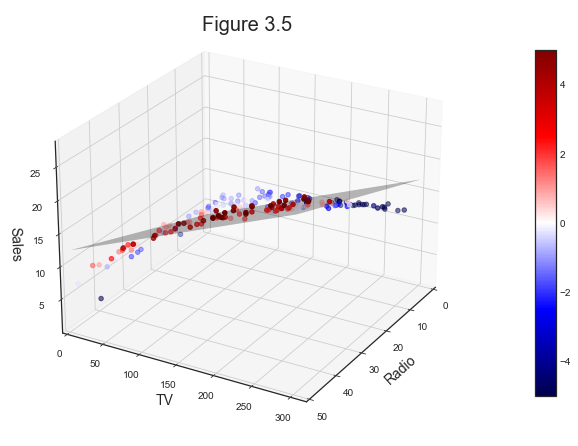

In [41]:
make_fig_3_5()

### Some Important Questions

How do you check whether the model fit well the data with multiple regressors? `statmodels` and most regression packages automatically outputs more information about the least squares model.

In [42]:
# Measires of fit
est.summary().tables[0]

<class 'statsmodels.iolib.table.SimpleTable'>

First measure: the **F-test**. The F-test tries to answe the question "*Is There a Relationship Between the Response and Predictors?*"

In particular, it tests the following hypothesis

$$
H_1: \text{is at least one coefficient different from zero?}
$$

against the null hypothesis

$$
H_0: \beta_0 = \beta_1 = ... = 0
$$

This hypothesis test is performed by computing the F-statistic,

$$
F=\frac{(\mathrm{TSS}-\mathrm{RSS}) / p}{\operatorname{RSS} /(n-p-1)}
$$

Let's try to compute it by hand.

In [43]:
# Init
X = advertising[['Radio', 'TV']]
y = advertising.Sales
e = y - est.predict(X)
RSS = np.sum(e**2)
TSS = np.sum((y - np.mean(y))**2)
(n,p) = np.shape(X)

# Compute F
F = ((TSS - RSS)/p) / (RSS/(n-p-1))
print('F = %.4f' % F)

F = 859.6177


A rule of thumb is to reject $H_0$ if $F > 10$.

We can also test that a particular subset of coefficients are equal to zero. In that case, we just substitute the Total Sum of Squares (TSS) with the Residual Sum of Squares under the null. 

$$
F=\frac{(\mathrm{RSS_0}-\mathrm{RSS}) / p}{\operatorname{RSS} /(n-p-1)}
$$

i.e. we perfome the regression under the null hypothesis and we compute

$$
RSS_0 = \sum_{n=1}^N (y_i - X_i \beta)^2 \quad s.t. \quad  H_0
$$

## 2.3 Other Considerations in the Regression Model

[*go to index*](#/1)

### Qualitative Predictors

What if some variables are qualitative instead of quantitative? Let's change dataset and use the `credit` dataset.

In [44]:
# Credit ratings dataset
credit = pd.read_csv('data/Credit.csv', usecols=list(range(1,12)))

This dataset contains information on credit ratings, i.e. each person is assigned a `Rating` score based on his/her own individual characteristics.

Let's have a look at data types.

In [45]:
# Summary
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 34.5+ KB


As we can see, some variables like `Gender`, `Student` or `Married` are not numeric.

We can have a closer look at what these variables look like.

In [46]:
# Look at data
credit.head()

Income  Limit  Rating  Cards  Age  Education  Gender Student Married  \
0   14.891   3606     283      2   34         11    Male      No     Yes   
1  106.025   6645     483      3   82         15  Female     Yes     Yes   
2  104.593   7075     514      4   71         11    Male      No      No   
3  148.924   9504     681      3   36         11  Female      No      No   
4   55.882   4897     357      2   68         16    Male      No     Yes   

   Ethnicity  Balance  
0  Caucasian      333  
1      Asian      903  
2      Asian      580  
3      Asian      964  
4  Caucasian      331

Let's consider the variable `Student`. From a quick inspection it looks like it's a binary *Yes/No* variable. Let's check by listing all its values.

In [47]:
# What values does the Student variable take?
credit['Student'].unique()

array(['No', 'Yes'], dtype=object)

What happens if you pass a binary varaible to `statsmodel`? It automatically generates a dummy out of it.

In [48]:
# Table 3.7
est = sm.OLS.from_formula('Balance ~ Student', credit).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

If a variable takes more than one value, `statsmodel` automatically generates a uniqe dummy for each level (-1).

In [49]:
# Table 3.8
est = sm.OLS.from_formula('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Relaxing the additive assumption

We have seen that both TV and Radio advertisement are positively associated with Sales. What if there is a synergy? For example it might be that if someone sees an ad *both* on TV and on the radio, s/he is much more likely to buy the product.

Consider the following model

$$
\text{Sales} ≈ \beta_0 + \beta_1 \text{TV} + \beta_2 \text{Radio} + \beta_3 \text{TV} \times \text{Radio}
$$

which can be rewritten as

$$
\text{Sales} ≈ \beta_0 + (\beta_1 + \beta_3 \text{Radio}) \times \text{TV} + \beta_2 \text{Radio}
$$

Let's estimate the linear regression model, with the intercept.

In [50]:
# Table 3.9 - Interaction Variables
est = sm.OLS.from_formula('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

A positive and significant interaction term indicates a hint of a sinergy effect.

### Heterogeneous effects

We can do interactions with qualitative variables as well. Conside the credit rating dataset. 

What if `Balance` depends by `Income` differently, depending on whether one is a `Student` or not?

Consider the following model:

$$
\text{Balance} ≈ \beta_0 + \beta_1 \text{Income} + \beta_2 \text{Student} + \beta_3 \text{Income} \times \text{Student}
$$

The last coefficient $\beta_3$ should tell us how much `Balance` increases in `Income` for `Students` with respect to non-Students.

Indeed, we can decompose the regression in the following equivalent way:

$$
\text{Balance} ≈ \beta_0 + \beta_1 \text{Income} + \beta_2 \text{Student} + \beta_3 \text{Income} \times \text{Student}
$$

which can be interpreted in the following way since `Student` is a binary variable
1. If the person is *not* a student
$$
\text{Balance} ≈ \beta_0 + \beta_1 \text{Income}
$$

2. If the person is a student
$$
\text{Balance} ≈ (\beta_0 + \beta_2) + (\beta_1 + \beta_3 ) \text{Income}
$$

We are allowing not only for a different intercept for `Students`, $\beta_0 \to \beta_0 + \beta_2$,  but also for a different impact of `Income`, $\beta_1 \to \beta_1 + \beta_3$.

We can visually inspect the distribution of `Income` across the two groups.

In [51]:
# Divide data into students and non-students
x_student = credit.loc[credit.Student=='Yes','Income']
y_student = credit.loc[credit.Student=='Yes','Balance']
x_nonstudent = credit.loc[credit.Student=='No','Income']
y_nonstudent = credit.loc[credit.Student=='No','Balance']

In [52]:
# Make figure 3.8
def make_fig_3_8():
    
    # Init figure
    fig, ax = plt.subplots(1,1)
    fig.suptitle('Figure 3.8')

    # Relationship betweeen income and balance for students and non-students
    ax.scatter(x=x_nonstudent, y=y_nonstudent, facecolors='None', edgecolors='k', alpha=0.5);
    ax.scatter(x=x_student, y=y_student, facecolors='r', edgecolors='r', alpha=0.7);
    ax.legend(['non-student', 'student']);
    ax.set_xlabel('Income'); ax.set_ylabel('Balance');

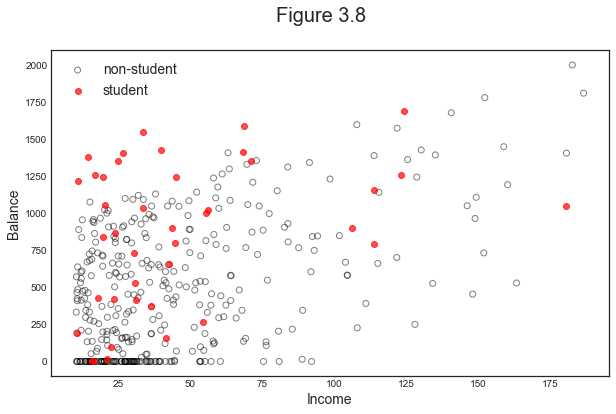

In [53]:
make_fig_3_8()

It is hard from the scatterplot to see whether there is a different relationship between income and balance for students and non-students.

Let's fit two separate regressions.

In [54]:
# Interaction between qualitative and quantative variables
est1 = sm.OLS.from_formula('Balance ~ Income + Student', credit).fit()
reg1 = est1.params
est2 = sm.OLS.from_formula('Balance ~ Income + Student + Income*Student', credit).fit()
reg2 = est2.params

print('Regression 1 - without interaction term')
print(reg1)
print('\nRegression 2 - with interaction term')
print(reg2)

Regression 1 - without interaction term
Intercept         211.142964
Student[T.Yes]    382.670539
Income              5.984336
dtype: float64

Regression 2 - with interaction term
Intercept                200.623153
Student[T.Yes]           476.675843
Income                     6.218169
Income:Student[T.Yes]     -1.999151
dtype: float64


Without the interaction term, the two lines have different levels but the same slope. Introducing an interaction term allows the two groups to have different responses to Income.

We can visualize the relationship in a graph.

In [55]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(reg1['Intercept']+reg1['Student[T.Yes]'],
                       reg1['Intercept']+reg1['Student[T.Yes]']+150*reg1['Income'])
non_student1 =  np.linspace(reg1['Intercept'], reg1['Intercept']+150*reg1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(reg2['Intercept']+reg2['Student[T.Yes]'],
                       reg2['Intercept']+reg2['Student[T.Yes]']+
                       150*(reg2['Income']+reg2['Income:Student[T.Yes]']))
non_student2 =  np.linspace(reg2['Intercept'], reg2['Intercept']+150*reg2['Income'])

In [56]:
# Figure 3.7
def make_fig_3_7():
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle('Figure 3.7')

    # Plot best fit with and without interaction
    ax1.plot(income, student1, 'r', income, non_student1, 'k')
    ax2.plot(income, student2, 'r', income, non_student2, 'k')

    for ax in fig.axes:
        ax.legend(['student', 'non-student'], loc=2)
        ax.set_xlabel('Income')
        ax.set_ylabel('Balance')
        ax.set_ylim(ymax=1550)

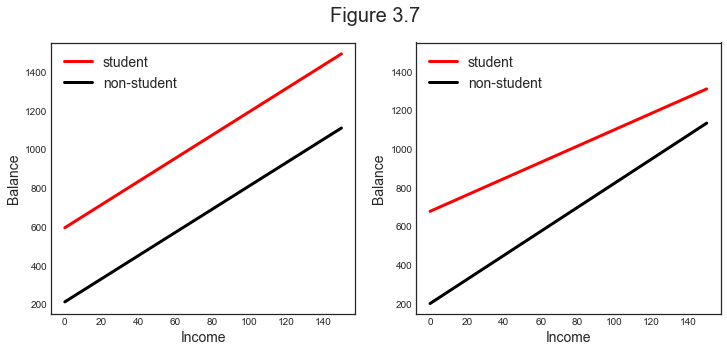

In [57]:
make_fig_3_7()

### Non-linear Relationships

What if we allow for further non-linearities? Let's change dataset again and use the `car` dataset.

In [58]:
# Automobile dataset (dropping missing values)
auto = pd.read_csv('data/Auto.csv', na_values='?').dropna()

This dataset contains information of a wide variety of car models.

In [59]:
auto.head()

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   
3  16.0          8         304.0         150    3433          12.0    70   
4  17.0          8         302.0         140    3449          10.5    70   

   origin                       name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino

Suppose we wanted to understand which car caracteristics are correlated with higher efficiency, i.e. `mpg` (miles per gallon).

Consider in particular the relationship between `mpg` and `horsepower`. It might be a highly non-linear relationship.

$$
\text{mpg} ≈ \beta_0 + \beta_1 \text{horsepower} + \beta_2 \text{horsepower}^2 + ... ???
$$

How many terms should we include?

Let's look at the data to understand if it naturally suggests non-linearities.

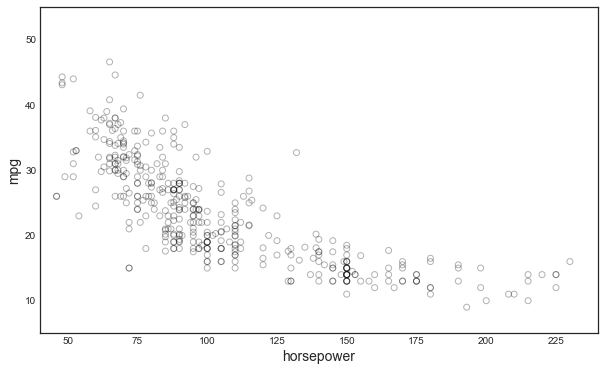

In [60]:
fig, ax = plt.subplots(1,1)

# Plot polinomials of different degree
plt.scatter(x=auto.horsepower, y=auto.mpg, facecolors='None', edgecolors='k', alpha=.3) 
plt.ylim(5,55); plt.xlim(40,240); 
plt.xlabel('horsepower'); plt.ylabel('mpg');

The relationship looks non-linear but in which way exactly? Let's try to fit polinomials of different degrees.

In [61]:
def make_fig_38():
    
    # Figure 3.8 
    fig, ax = plt.subplots(1,1)
    ax.set_title('Figure 3.8')

    # Plot polinomials of different degree
    plt.scatter(x=auto.horsepower, y=auto.mpg, facecolors='None', edgecolors='k', alpha=.3) 
    sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
    sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
    sns.regplot(x=auto.horsepower, y=auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
    plt.legend()
    plt.ylim(5,55)
    plt.xlim(40,240);

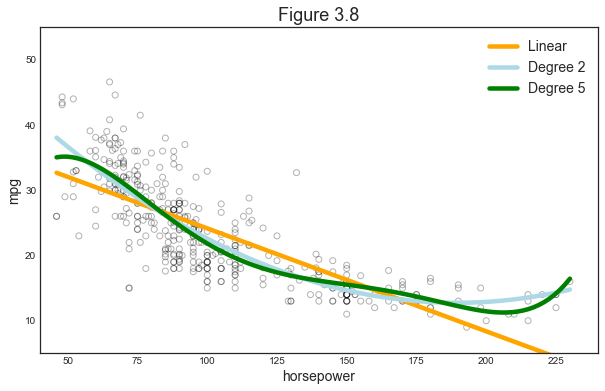

In [62]:
make_fig_38()

As we can see, the tails are highly unstable depending on the specification.

Let's add a quadratic term

In [63]:
# Table 3.10
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
0  18.0          8         307.0         130    3504          12.0    70   
1  15.0          8         350.0         165    3693          11.5    70   
2  18.0          8         318.0         150    3436          11.0    70   

   origin                       name  horsepower2  
0       1  chevrolet chevelle malibu        16900  
1       1          buick skylark 320        27225  
2       1         plymouth satellite        22500

How does the regression change?

In [64]:
est = sm.OLS.from_formula('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

### Non-linearities

How can we assess if there are non-linearities and of which kind? We can look at the residuals.

If the residuals show some kind of pattern, probably we could have fit the line better. Moreover, we can use the pattern itself to understand how.

In [65]:
# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr = LinearRegression().fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']]
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

In [66]:
# Figure 3.9
def make_fig_39():
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
    fig.suptitle('Figure 3.9')

    # Left plot
    sns.regplot(x=auto.pred1, y=auto.resid1, lowess=True, 
                ax=ax1, line_kws={'color':'r', 'lw':1},
                scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
    ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
               xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
    ax1.set_title('Residual Plot for Linear Fit')

    # Right plot
    sns.regplot(x=auto.pred2, y=auto.resid2, lowess=True,
                line_kws={'color':'r', 'lw':1}, ax=ax2,
                scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
    ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
               xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
    ax2.set_title('Residual Plot for Quadratic Fit')

    for ax in fig.axes:
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')

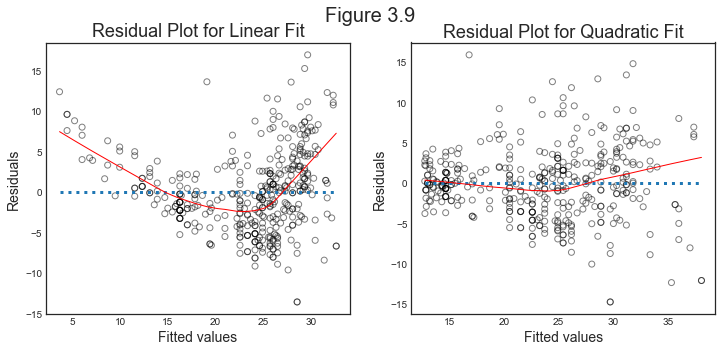

In [67]:
 make_fig_39()

### Outliers

Observations with high residuals have a good chance of being highly influentials. However, they do not have to be.

Let's use the following data generating process:
- $X \sim N(0,1)$
- $\varepsilon \sim N(0,0.5)$
- $\beta_0 = 3$
- $y = \beta_0 X + \varepsilon$

In [68]:
np.random.seed(1)

# Generate random y
n = 50
X = rnorm(1,1,(n,1))
e = rnorm(0,0.5,(n,1))
b0 = 3
y = X*b0 + e

Now let's change observation 7 so that it becomes an outlier, i.e. it has a high residual.

In [69]:
# Generate outlier
X[20] = 1
y[20] = 7

# Short regression without observation number 41
X_small = np.delete(X, 20)
y_small = np.delete(y, 20)

Let's now plot the data and the residuals

In [70]:
# Figure 3.12
def make_fig_3_12():
    
    # Init figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
    fig.suptitle('Figure 3.12')

    # Plot 1
    ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
    sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
    sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); 
    ax1.legend(['With obs. 20', 'Without obs. 20'], fontsize=12);

    # Hihglight outliers
    ax1.scatter(x=X[20], y=y[20], facecolors='None', edgecolors='r', alpha=1) 
    ax1.annotate("20", (1.1, 7), color='r')

    # Compute fitted values and residuals
    r = regr.fit(X, y)
    y_hat = r.predict(X)
    e = np.abs(y - y_hat)

    # Plot 2
    ax2.scatter(x=y_hat, y=e, facecolors='None', edgecolors='k', alpha=.5)
    ax2.set_xlabel('Fitted Values'); ax2.set_ylabel('Residuals');
    ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
               xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')

    # Highlight outlier
    ax2.scatter(x=y_hat[20], y=e[20], facecolors='None', edgecolors='r', alpha=1) 
    ax2.annotate("20", (2.2, 3.6), color='r');

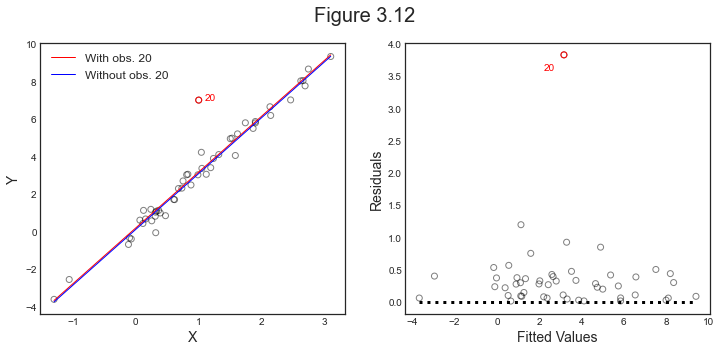

In [71]:
make_fig_3_12()

### High Leverage Points

A better concept of "influential observation" is the Leverage, which represents how much an observation is distant from the others in terms of observables.

The leverage formula of observation $i$ is

$$
h_i = x_i (X' X)^{-1} x_i'
$$

However, leverage alone is not necessarily enough for an observation to being highly influential.

In [72]:
# Generate observation with high leverage
X[41] = 4
y[41] = 12

# Short regression without observation number 41
X_small = np.delete(X_small, 41)
y_small = np.delete(y_small, 41)

# Compute leverage
H = X @ inv(X.T @ X) @ X.T
h = np.diagonal(H)

# Compute fitted values and residuals
y_hat = X @ inv(X.T @ X) @ X.T @ y
e = np.abs(y - y_hat) 

What happens now that we have added an observation with high leverage? How does the levarage look like?

In [73]:
# Figure 3.13
def make_fig_3_13():

    # Init figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
    fig.suptitle('Figure 3.12')

    # Plot 1
    ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
    ax1.scatter(x=X[[20,41]], y=y[[20,41]], facecolors='None', edgecolors='r', alpha=1) 
    sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
    sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.axis(xmax=4.5);
    ax1.legend(['With obs. 20,41', 'Without obs. 20,41']);

    # Highlight points
    ax1.annotate("20", (1.1, 7), color='r')
    ax1.annotate("41", (3.6, 12), color='r');



    # Plot 2
    ax2.scatter(x=h, y=e, facecolors='None', edgecolors='k', alpha=.5)
    ax2.set_xlabel('Leverage'); ax2.set_ylabel('Residuals'); 
    ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
               xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')
    # Highlight outlier
    ax2.scatter(x=h[[20,41]], y=e[[20,41]], facecolors='None', edgecolors='r', alpha=1);

    # Highlight points
    ax2.annotate("20", (0, 3.6), color='r')
    ax2.annotate("41", (0.14, 0.2), color='r');

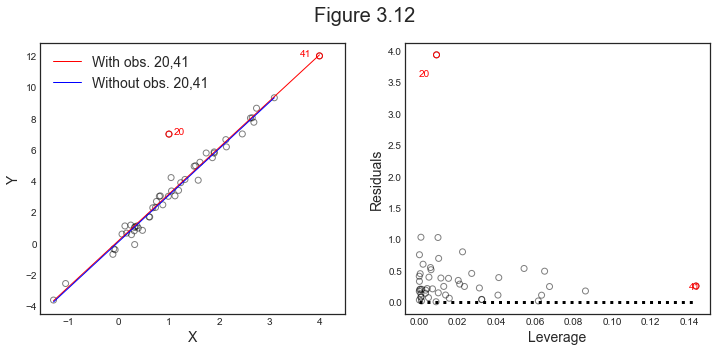

In [74]:
make_fig_3_13()

### Influential Observations

As we have seen, being an outliers or having high leverage alone might be not enough to conclude that an observation is influential.

What really matters is a combination of both: observations with high leverage and high residuals, i.e. observations that are not only different in terms of observables (high leverage) but are also different in terms of their relationship between observables and dependent variable (high residual).

Let's now add an observation that is both an outlier and has high leverage.

In [75]:
# Generate outlier with high leverage
X[7] = 4
y[7] = 7

In [76]:
# Short regression without observation number 41
X_small = np.delete(X, 7)
y_small = np.delete(y, 7)

# Compute leverage
H = X @ inv(X.T @ X) @ X.T
h = np.diagonal(H)

# Compute fitted values and residuals
r = regr.fit(X, y)
y_hat = r.predict(X)
e = np.abs(y - y_hat)

Now the best linear fit line has noticeably moved.

In [77]:
def make_fig_extra_3():

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 

    # Plot 1
    ax1.scatter(x=X, y=y, facecolors='None', edgecolors='k', alpha=.5) 
    ax1.scatter(x=X[[7,20,41]], y=y[[7,20,41]], facecolors='None', edgecolors='r', alpha=1) 
    sns.regplot(x=X, y=y, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'r', 'lw':1})
    sns.regplot(x=X_small, y=y_small, ax=ax1, order=1, ci=None, scatter=False, line_kws={'color':'b', 'lw':1})
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.axis(xmax=4.5);
    ax1.legend(['With obs. 7,20,41', 'Without obs. 7,20,41']);

    # Highlight points
    ax1.annotate("7", (3.7, 7), color='r')
    ax1.annotate("20", (1.1, 7), color='r')
    ax1.annotate("41", (3.6, 12), color='r');



    # Plot 2
    ax2.scatter(x=h, y=e, facecolors='None', edgecolors='k', alpha=.5)
    ax2.set_xlabel('Leverage'); ax2.set_ylabel('Residuals'); 
    ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
               xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted',color='k')
    # Highlight outlier
    ax2.scatter(x=h[[7,20,41]], y=e[[7,20,41]], facecolors='None', edgecolors='r', alpha=1);

    # Highlight points
    ax2.annotate("7", (0.13, 3.8), color='r');
    ax2.annotate("20", (0, 3.8), color='r')
    ax2.annotate("41", (0.13, 1.1), color='r');

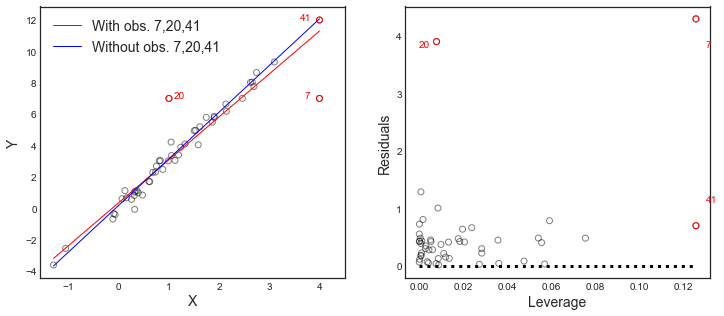

In [78]:
make_fig_extra_3()

### Collinearity

Collinearity is the situation in which two dependent varaibles are higly correlated with each other. Algebraically, this is a problem because the $X'X$ matrix becomes almost-non-invertible.

Let's have a look at the `ratings` dataset.

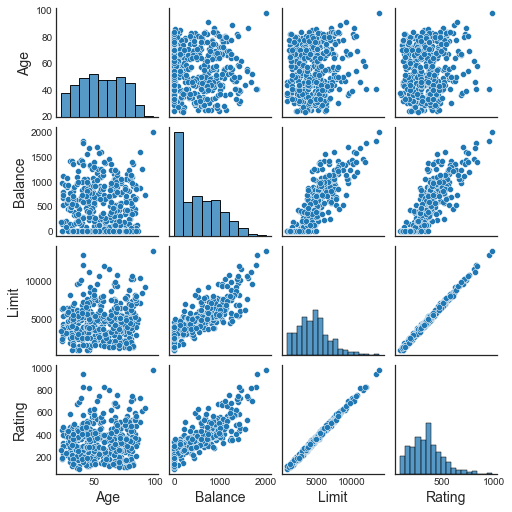

In [79]:
# Inspect dataset
sns.pairplot(credit[['Age', 'Balance', 'Limit', 'Rating']], height=1.8);

If we zoom into the variable `Limit`, we see that for example it is not very correlated with `Age` but is very correlated with `Rating`.

In [80]:
# Figure 3.14
def make_fig_3_14():
    
    # Init figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
    fig.suptitle('Figure 3.14')

    # Left plot
    ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='brown')
    ax1.set_ylabel('Age')

    # Right plot
    ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='brown')
    ax2.set_ylabel('Rating')

    for ax in fig.axes:
        ax.set_xlabel('Limit')
        ax.set_xticks([2000,4000,6000,8000,12000])

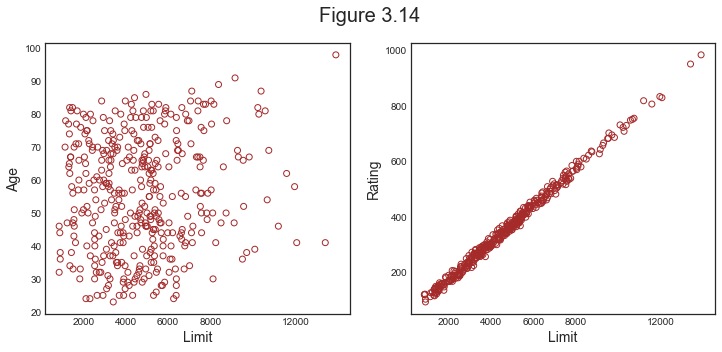

In [81]:
make_fig_3_14()

If we regress `Balance` on `Limit` and `Age`, the coefficient of `Limit` is positive and highly significant.

In [82]:
# Regress balance on limit and age
reg1 = sm.OLS.from_formula('Balance ~ Limit + Age', credit).fit()
reg1.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

However, if we regress `Balance` on `Limit` and `Rating`, the coefficient of `Limit` is now not significant anymore.

In [83]:
# Regress balance on limit and rating
reg2 = sm.OLS.from_formula('Balance ~ Limit + Rating', credit).fit()
reg2.summary().tables[1]

<class 'statsmodels.iolib.table.SimpleTable'>

Looking at the objective function, the Residual Sum of Squares, helps understanding what is the problem.

In [84]:
# First scale variables
y = credit.Balance
regr1 = LinearRegression().fit(scale(credit[['Age', 'Limit']].astype('float'), with_std=False), y)
regr2 = LinearRegression().fit(scale(credit[['Rating', 'Limit']], with_std=False), y)

# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

In [85]:
# Figure 3.15
def make_fig_3_15():

    # Init figure
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5)) 
    fig.suptitle('Figure 3.15')

    # Minimum
    min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'

    # Left plot
    CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
    ax1.scatter(reg1.params[1], reg1.params[2], c='r', label=min_RSS)
    ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
    ax1.set_ylabel(r'$\beta_{Age}$')

    # Right plot
    CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
    ax2.scatter(reg2.params[1], reg2.params[2], c='r', label=min_RSS)
    ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
    ax2.set_ylabel(r'$\beta_{Rating}$')
    #ax2.set_xticks([-0.1, 0, 0.1, 0.2])

    for ax in fig.axes:
        ax.set_xlabel(r'$\beta_{Limit}$')
        ax.legend()

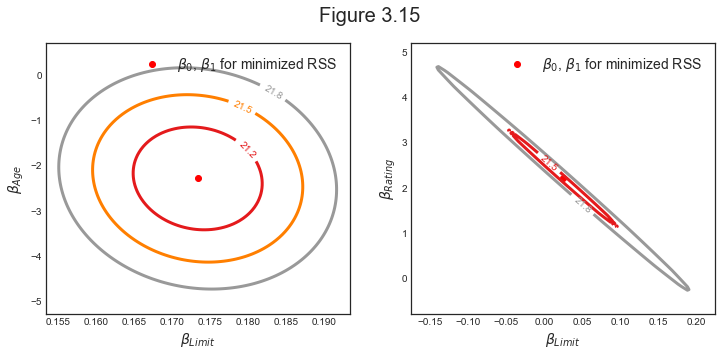

In [86]:
make_fig_3_15()

As we can see, in the left plot the minimum is much better defined than in the right plot.

## Next Session

Jump to [Session 2 - Instrumental Variables](https://matteocourthoud.github.io/course/ml-econ/2-iv/)